<a href="https://colab.research.google.com/github/russell-ai/SparkNLP-CustomNER/blob/main/1_Pipeline_Implementation_with_Chunk_Merger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

# **Interview Task**
[Running a Spark NLP Healthcare Pipeline and Training a Custom NER Model](https://docs.google.com/document/d/1l_SpYGAlVGAEe9x-b8avgvKipCXetdap2ttc4UKreO4/edit?tab=t.0)  
## **PART-I Pipeline Implementation:**


## 1. Set Up Spark NLP for Healthcare

In [1]:
import json
import os

from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_jsl.json')

with open('spark_jsl.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)
os.environ.update(license_keys)

In [2]:
license_keys.keys()

dict_keys(['SPARK_NLP_LICENSE', 'SECRET', 'JSL_VERSION', 'PUBLIC_VERSION', 'AWS_ACCESS_KEY_ID', 'AWS_SECRET_ACCESS_KEY', 'AWS_SESSION_TOKEN'])

In [3]:
license_keys['JSL_VERSION']

'5.4.1'

In [4]:
license_keys['PUBLIC_VERSION']

'5.4.1'

In [5]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.4.1 spark-nlp==$PUBLIC_VERSION


# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

In [6]:
import json
import os

import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp_jsl.pipeline_tracer import PipelineTracer
from sparknlp_jsl.pipeline_output_parser import PipelineOutputParser

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline,PipelineModel

import pandas as pd
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G",
          "spark.kryoserializer.buffer.max":"2000M",
          "spark.driver.maxResultSize":"2000M"}

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

spark

Spark NLP Version : 5.4.1
Spark NLP_JSL Version : 5.4.1


In [7]:
from sparknlp_jsl.pretrained import InternalResourceDownloader

ner_models = InternalResourceDownloader.returnPrivateModels("MedicalNerModel")
for model, lang, version in ner_models:
  if lang == "en" and (model.startswith("ner_clinical") or model.startswith("ner_posology") or model.startswith("ner_deid_generic")):
    print(model)

ner_clinical
ner_posology
ner_posology_small
ner_posology_greedy
ner_posology_large
ner_clinical_large
ner_posology_healthcare
ner_posology_large_biobert
ner_clinical_biobert
ner_posology_biobert
ner_deid_generic_augmented
ner_deid_generic_glove
ner_deid_generic_augmented
ner_posology_experimental
ner_clinical_trials_abstracts
ner_posology_emb_clinical_medium
ner_posology_emb_clinical_large
ner_posology_langtest
ner_deid_generic_augmented_langtest
ner_clinical_langtest
ner_deid_generic_augmented_allUpperCased_langtest
ner_clinical_large_langtest
ner_clinical_abbreviation_langtest
ner_deid_generic_docwise


In [8]:
pipeline_ner_models = {
    "ner_clinical": "ner_clinical",
    "ner_posology": "ner_posology_greedy",
    "ner_deid_generic": "ner_deid_generic_augmented"}

## 2. Dataset Selection

In [9]:
# mt_samples dataset from John Snow Labs
# ! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/mt_samples_10.csv
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/refs/heads/master/healthcare-nlp/data/mt_samples.csv

In [10]:
df = pd.read_csv("mt_samples.csv")
print("Rows:", df.shape[0], " Columns:", df.shape[1])
df.head(5)

Rows: 50  Columns: 1


,text
0,"Sample Type / Medical Specialty:\nHematology - Oncology\nSample Name:\nDischarge Summary - Mesothelioma - 1\nDescription:\nMesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, eso..."
1,"Sample Type / Medical Specialty:\nHematology - Oncology\nSample Name:\nBCCa Excision - Lower Lid\nDescription:\nExcision of large basal cell carcinoma, right lower lid, and repaired with used dors..."
2,"Sample Type / Medical Specialty:\nHematology - Oncology\nSample Name:\nAnemia - Consult\nDescription:\nRefractory anemia that is transfusion dependent. At this time, he has been admitted for anemi..."
3,Sample Type / Medical Specialty:\nHematology - Oncology\nSample Name:\nIntensity-Modulated Radiation Therapy\nDescription:\nIntensity-modulated radiation therapy is a complex set of procedures whi...
4,"Sample Type / Medical Specialty:\nHematology - Oncology\nSample Name:\nNeck Dissection\nDescription:\nLeft neck dissection. Metastatic papillary cancer, left neck. The patient had thyroid cancer, ..."


In [11]:
mt_samples_df = spark.createDataFrame(df)
print("Rows:", mt_samples_df.count(), " Columns:", len(mt_samples_df.columns), "Schema:", mt_samples_df,"\n")
mt_samples_df.show(5,truncate=100)

Rows: 50  Columns: 1 Schema: DataFrame[text: string] 

+----------------------------------------------------------------------------------------------------+
|                                                                                                text|
+----------------------------------------------------------------------------------------------------+
|Sample Type / Medical Specialty:\nHematology - Oncology\nSample Name:\nDischarge Summary - Mesoth...|
|Sample Type / Medical Specialty:\nHematology - Oncology\nSample Name:\nBCCa Excision - Lower Lid\...|
|Sample Type / Medical Specialty:\nHematology - Oncology\nSample Name:\nAnemia - Consult\nDescript...|
|Sample Type / Medical Specialty:\nHematology - Oncology\nSample Name:\nIntensity-Modulated Radiat...|
|Sample Type / Medical Specialty:\nHematology - Oncology\nSample Name:\nNeck Dissection\nDescripti...|
+----------------------------------------------------------------------------------------------------+
only showing top 5

In [12]:
print(mt_samples_df.limit(1).collect()[0]['text'])

Sample Type / Medical Specialty:
Hematology - Oncology
Sample Name:
Discharge Summary - Mesothelioma - 1
Description:
Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.
(Medical Transcription Sample Report)
PRINCIPAL DIAGNOSIS:
Mesothelioma.
SECONDARY DIAGNOSES:
Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.
PROCEDURES
1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy.
2. On August 20, 2007, thoracentesis.
3. On August 31, 2007, Port-A-Cath placement.
HISTORY AND PHYSICAL:
The patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to an urgent care cen

## 3. NER Pipeline Execution:

### Pipeline

In [13]:
def get_pipeline_model(embeddings, models: dict):
  # Document assembler
  document_assembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("document")

  # Sentence detector
  sentence_detector = SentenceDetector()\
      .setInputCols(["document"])\
      .setOutputCol("sentence")

  # Tokenizer
  tokenizer = Tokenizer()\
      .setInputCols(["sentence"])\
      .setOutputCol("token")

  # Word Embeddings
  embeddings = WordEmbeddingsModel.pretrained(embeddings, "en", "clinical/models")\
      .setInputCols(["sentence", "token"])\
      .setOutputCol("embeddings")

  # NER models
  ner_clinical = MedicalNerModel.pretrained(models["ner_clinical"], "en", "clinical/models")\
      .setInputCols(["sentence", "token", "embeddings"])\
      .setOutputCol("ner_clinical")

  ner_posology_greedy = MedicalNerModel.pretrained(models["ner_posology"], "en", "clinical/models")\
      .setInputCols(["sentence", "token", "embeddings"])\
      .setOutputCol("ner_posology")

  ner_deid_generic = MedicalNerModel.pretrained(models["ner_deid_generic"], "en", "clinical/models")\
      .setInputCols(["sentence", "token", "embeddings"])\
      .setOutputCol("ner_deid")

  # NER Converters
  ner_conv_clinical = NerConverterInternal()\
      .setInputCols(["sentence", "token", "ner_clinical"])\
      .setOutputCol("ner_chunk_clinical")

  ner_conv_posology = NerConverterInternal()\
      .setInputCols(["sentence", "token", "ner_posology"])\
      .setOutputCol("ner_chunk_posology")\
      .setWhiteList(["DRUG"])

  ner_conv_deid = NerConverterInternal()\
      .setInputCols(["sentence", "token", "ner_deid"])\
      .setOutputCol("ner_chunk_deid")\
      .setWhiteList(["NAME", "DATE"])

  # Chunk Merger
  chunk_merger = ChunkMergeApproach()\
      .setInputCols(["ner_chunk_clinical", "ner_chunk_posology", "ner_chunk_deid"])\
      .setOutputCol("merged_chunks")\
      .setMergeOverlapping(True)\
      .setSelectionStrategy("Sequential")\
      .setChunkPrecedence("ner_source,entity")\
      .setChunkPrecedenceValuePrioritization(["ner_chunk_posology,DRUG", "ner_chunk_deid,NAME", "ner_chunk_deid,DATE", "ner_chunk_clinical,*"])

  # Pipeline
  model = Pipeline(
      stages=[
          document_assembler,
          sentence_detector,
          tokenizer,
          embeddings,
          ner_clinical,
          ner_posology_greedy,
          ner_deid_generic,
          ner_conv_clinical,
          ner_conv_posology,
          ner_conv_deid,
          chunk_merger
      ]
  )

  return model.fit(spark.createDataFrame([[""]]).toDF("text"))


In [14]:
embeddings = 'embeddings_clinical'
light_pipeline_model = get_pipeline_model(embeddings, pipeline_ner_models)
light_model = LightPipeline(light_pipeline_model)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
[OK!]
ner_posology_greedy download started this may take some time.
[OK!]
ner_deid_generic_augmented download started this may take some time.
[OK!]


### Test pipeline

In [15]:
# Run the pipeline
text = "Patient John Doe was prescribed 500mg of Aspirin on 2023-05-15 for his chronic pain."
light_result = light_model.fullAnnotate(text)
from pprint import pprint
pprint(light_result)

[{'document': [Annotation(document, 0, 83, Patient John Doe was prescribed 500mg of Aspirin on 2023-05-15 for his chronic pain., {}, [])],
  'embeddings': [Annotation(word_embeddings, 0, 6, Patient, {'isOOV': 'false', 'pieceId': '-1', 'isWordStart': 'true', 'token': 'Patient', 'sentence': '0'}, []),
                 Annotation(word_embeddings, 8, 11, John, {'isOOV': 'false', 'pieceId': '-1', 'isWordStart': 'true', 'token': 'John', 'sentence': '0'}, []),
                 Annotation(word_embeddings, 13, 15, Doe, {'isOOV': 'false', 'pieceId': '-1', 'isWordStart': 'true', 'token': 'Doe', 'sentence': '0'}, []),
                 Annotation(word_embeddings, 17, 19, was, {'isOOV': 'false', 'pieceId': '-1', 'isWordStart': 'true', 'token': 'was', 'sentence': '0'}, []),
                 Annotation(word_embeddings, 21, 30, prescribed, {'isOOV': 'false', 'pieceId': '-1', 'isWordStart': 'true', 'token': 'prescribed', 'sentence': '0'}, []),
                 Annotation(word_embeddings, 32, 36, 500mg, 

In [16]:
light_result[0]["merged_chunks"]

[Annotation(chunk, 8, 15, John Doe, {'entity': 'NAME', 'confidence': '0.93275', 'ner_source': 'ner_chunk_deid', 'chunk': '0', 'sentence': '0'}, []),
 Annotation(chunk, 32, 47, 500mg of Aspirin, {'entity': 'DRUG', 'confidence': '0.5992333', 'ner_source': 'ner_chunk_posology', 'chunk': '1', 'sentence': '0'}, []),
 Annotation(chunk, 52, 61, 2023-05-15, {'entity': 'DATE', 'confidence': '1.0', 'ner_source': 'ner_chunk_deid', 'chunk': '2', 'sentence': '0'}, []),
 Annotation(chunk, 67, 82, his chronic pain, {'entity': 'PROBLEM', 'confidence': '0.9429333', 'ner_source': 'ner_chunk_clinical', 'chunk': '3', 'sentence': '0'}, [])]

In [17]:
[item.result for item in light_result[0]["merged_chunks"]]

['John Doe', '500mg of Aspirin', '2023-05-15', 'his chronic pain']

### Extract **merged_chunks** from the mt_samples via the pipeline

#### Prepare input texts

In [18]:
# total_rows = mt_samples_df.count()
# texts = [mt_samples_df.select("text").collect()[i]['text'] for i in range(total_rows)]
# from pyspark.sql.functions import monotonically_increasing_id
# texts = mt_samples_df.select("text").withColumn("text_id", monotonically_increasing_id()).collect()

In [19]:
texts = mt_samples_df.select("text").rdd.flatMap(lambda x: x).collect()
print(f"Rows: {len(texts)} Type: {type(texts)} Element Type: {type(texts[0])}")

Rows: 50 Type: <class 'list'> Element Type: <class 'str'>


In [20]:
print(texts[0])

Sample Type / Medical Specialty:
Hematology - Oncology
Sample Name:
Discharge Summary - Mesothelioma - 1
Description:
Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.
(Medical Transcription Sample Report)
PRINCIPAL DIAGNOSIS:
Mesothelioma.
SECONDARY DIAGNOSES:
Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.
PROCEDURES
1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy.
2. On August 20, 2007, thoracentesis.
3. On August 31, 2007, Port-A-Cath placement.
HISTORY AND PHYSICAL:
The patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to an urgent care cen

#### **Getting prediction**

In [21]:
# Initialize lists to store all predictions
text_ids = []
chunks = []
entities = []
sentence_ids = []
begins = []
ends = []
confidences = []

# Process each text through the pipeline
for idx, text in enumerate(texts[:]):
    # Get predictions for current text
    light_result = light_model.fullAnnotate(text)

    # Extract predictions from each text
    for annotation in light_result[0]['merged_chunks']:
        text_ids.append(idx)
        begins.append(annotation.begin)
        ends.append(annotation.end)
        chunks.append(annotation.result)
        entities.append(annotation.metadata['entity'])
        sentence_ids.append(annotation.metadata['sentence'])
        confidences.append(annotation.metadata['confidence'])

# Create DataFrame with all predictions
result_df = pd.DataFrame({
    'text_id': text_ids,
    'begin': begins,
    'end': ends,
    'chunk': chunks,
    'entity': entities,
    'sentence_id': sentence_ids,
    'confidence': confidences
})

# Display the first few rows to verify structure
print("Number of extracted entities:", len(result_df))
print("\nFirst ten rows:")
result_df.head(10)

Number of extracted entities: 4317

First ten rows:


,text_id,begin,end,chunk,entity,sentence_id,confidence
0,0,88,99,Mesothelioma,PROBLEM,0,0.973
1,0,118,129,Mesothelioma,PROBLEM,0,0.9993
2,0,132,147,pleural effusion,PROBLEM,0,0.99609995
3,0,150,168,atrial fibrillation,PROBLEM,0,0.99815
4,0,171,176,anemia,PROBLEM,0,0.9992
5,0,179,185,ascites,PROBLEM,0,0.9996
6,0,188,204,esophageal reflux,PROBLEM,0,0.99665
7,0,222,243,deep venous thrombosis,PROBLEM,0,0.95006675
8,0,305,316,Mesothelioma,PROBLEM,1,0.9967
9,0,340,355,Pleural effusion,PROBLEM,2,0.97895


In [22]:
print("Last ten rows:")
result_df.tail(10)

Last ten rows:


,text_id,begin,end,chunk,entity,sentence_id,confidence
4307,49,5701,5717,estrogen receptor,DRUG,90,0.58185
4308,49,5720,5728,her 2 neu,PROBLEM,90,0.629
4309,49,5731,5759,"tnm, axillary node dissection",PROBLEM,90,0.71064
4310,49,5762,5770,tamoxifen,DRUG,90,0.9874
4311,49,5773,5801,infiltrating ductal carcinoma,PROBLEM,90,0.9763333
4312,49,5804,5823,upper outer quadrant,PROBLEM,90,0.79406667
4313,49,5826,5841,ductal carcinoma,PROBLEM,90,0.97440004
4314,49,5844,5860,"breast, carcinoma",PROBLEM,90,0.7565667
4315,49,5863,5877,"axillary, chest",PROBLEM,90,0.56093335
4316,49,5880,5888,mammogram,TEST,90,0.3922


In [23]:
print(result_df['entity'].value_counts())

entity
PROBLEM      2111
TREATMENT     854
TEST          779
DRUG          424
DATE          130
NAME           19
Name: count, dtype: int64


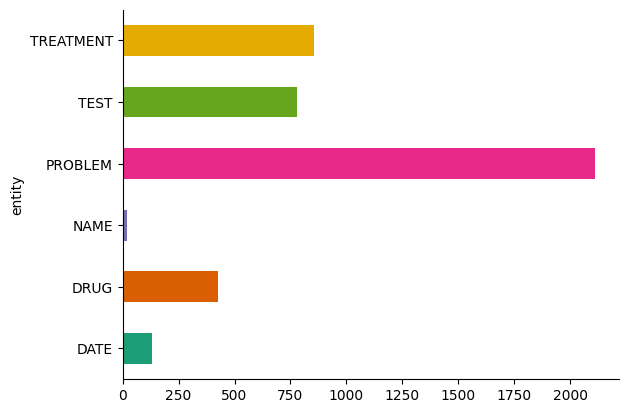

In [24]:
from matplotlib import pyplot as plt
import seaborn as sns
result_df.groupby('entity').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

#### **Save** the NER results and associated texts as a csv file.

In [25]:
result_df.to_csv("ner_clinical_mtsamples_ner_results_for_conll.csv", index=False)
text_df = pd.DataFrame({'text_id': range(len(texts)), 'text': texts})
text_df.to_csv("mtsamples_texts.csv", index=False)



---
***R.Caliskan***
